Lab 5 | Discrete cosine transformation (DCT)

Made by Dmitriy Sokolov, 3530901/00203

Firstly, prepare the environment

In [1]:
from labs.install_deps import require_think_dsp

require_think_dsp()

thinkdsp.py successfully download


-----
### Part 1

Measure time/difference between `analyze2` ($O(n^2 )$) and `analyze1` ($O(n^3 )$) execution speed

In [2]:
import numpy as np

PI2 = np.pi * 2

def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

In [3]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = M.dot(ys) / 2
    return amps

In [4]:
import scipy.fftpack

def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)

We will measure this funs on uncorrelated noise

In [5]:
from labs.thinkdsp import UncorrelatedGaussianNoise

signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384) # sqrt(16384) = 128 = 2^7
noise.ys.shape

(16384,)

In [6]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
from labs.thinkdsp import decorate

loglog = dict(xscale='log', yscale='log')

def plot_bests(ns, bests, color='b'):
    plt.plot(ns, bests, color=color)
    decorate(**loglog)

    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]

    return slope

In [7]:
def measure_fun(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = noise.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)

    bests = [result.best for result in results]
    return bests

tests frequencies:

In [8]:
ns = 2 ** np.arange(6, 13)
ns

array([  64,  128,  256,  512, 1024, 2048, 4096], dtype=int32)

In [9]:
bests1 = measure_fun(ns, analyze1)

64
86.6 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
273 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
1.08 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
512
7.07 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
29.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
194 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
1.39 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
bests2 = measure_fun(ns, analyze2)

64
50.9 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
151 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
256
523 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
512
3.08 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
12.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
2048
48.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
186 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [11]:
bests3 = measure_fun(ns, scipy_dct)

64
6.46 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
128
6.86 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
256
7.33 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
512
8.65 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
1024
10.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
2048
15.5 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
4096
26.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


analyze1 vs analyze2 vs spicy_dst comparison in plot:

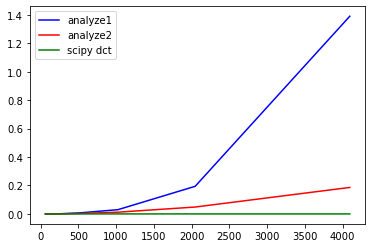

In [12]:
plt.plot(ns, bests1, label='analyze1', color='b')
plt.plot(ns, bests2, label='analyze2', color='r')
plt.plot(ns, bests3, label='scipy dct', color='g')
plt.legend()

2.34437180931592

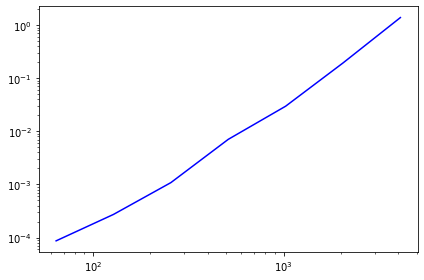

In [13]:
plot_bests(ns, bests1, 'b')

2.0251624009532616

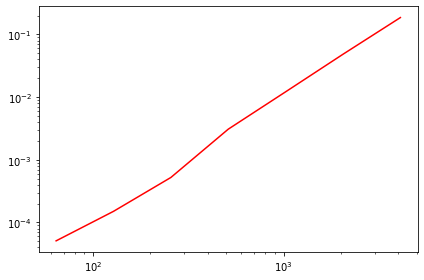

In [14]:
plot_bests(ns, bests2, 'r')

0.31944043000839495

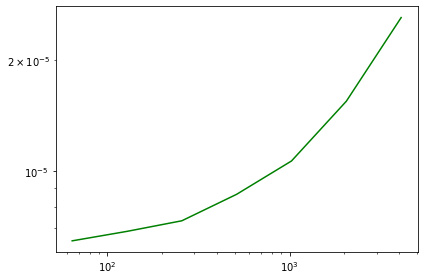

In [15]:
plot_bests(ns, bests3, 'g')

Expected, that slope of analyze1 and analyze2 would be near with 3 and 2. But they are both close to 2.
But one of things expected is analyze2 faster, than analyze1.
And scipy sct is faster than others.

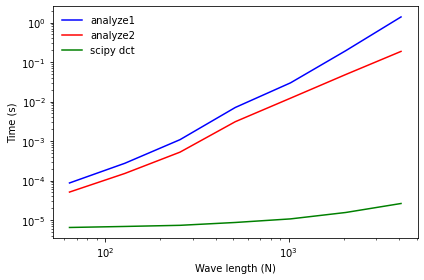

In [16]:
plt.plot(ns, bests1, label='analyze1', color='b')
plt.plot(ns, bests2, label='analyze2', color='r')
plt.plot(ns, bests3, label='scipy dct', color='g')
decorate(xlabel='Wave length (N)', ylabel='Time (s)', **loglog)

-----

### Part 2

Implement *DCT* for sounds & images compression.

Download the sound: [Epic music](https://freesound.org/people/BaDoink/sounds/546921/) and cut it.

In [17]:
from labs.thinkdsp import read_wave

wave = read_wave('546921__badoink__epic.wav')
wave.make_audio()

And short segment:

In [18]:
segment = wave.segment(start=0.5, duration=1)
segment.normalize()
segment.make_audio()

*DCT* of the segment:

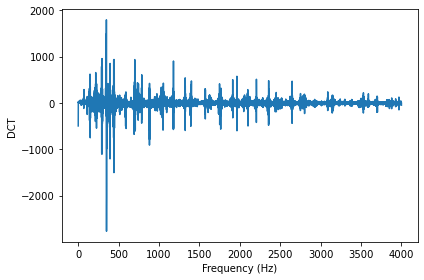

In [19]:
from labs.thinkdsp import decorate

seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

There are so many harmonics which are far from zero. And the fundamental near with 500 Hz.

In [20]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1

    n = len(dct.amps)
    print('removed: ' + str(count), 'total: ' + str(n), 'removed, %: ' + str(100 * count / n), sep='\t')

Remove frequencies with absolute amplitude values < 10.

removed: 28596	total: 44100	removed, %: 64.84353741496598


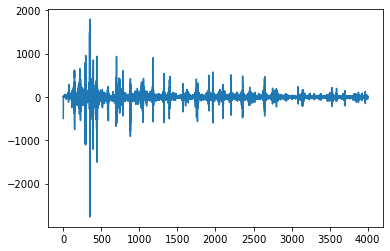

In [21]:
import numpy as np
seg_dct = segment.make_dct()
compress(seg_dct, thresh=10)
seg_dct.plot(high=4000)

The result audio sounds the same as original.

In [22]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

Try to drop more components:

removed: 39259	total: 44100	removed, %: 89.02267573696145


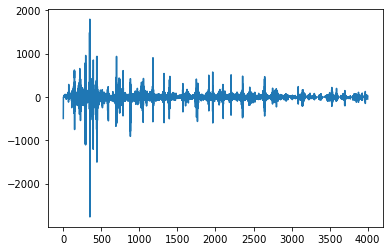

In [23]:
seg_dct3 = segment.make_dct()
compress(seg_dct3, thresh=30)
seg_dct3.plot(high=4000)

In [24]:
seg4 = seg_dct3.make_wave()
seg4.make_audio()

Oh, no... `trash=30` is too much... At the end we can hear artificial noise and screeching...

removed: 36050	total: 44100	removed, %: 81.74603174603175


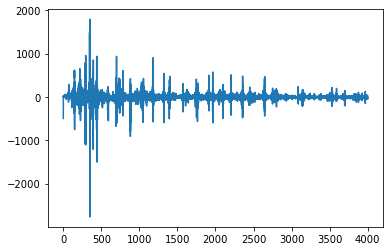

In [25]:
seg_dct2 = segment.make_dct()
compress(seg_dct2, thresh=20)
seg_dct2.plot(high=4000)

Even if we remove all components < 20 (*2 measuring with the previous result!),
the sound still sounds like original (it is actual for me).

And this way we can drop ~ 81% components.

But with trash = 30, we can hear quality losses.

In [26]:
seg3 = seg_dct2.make_wave()
seg3.make_audio()

And now, compress longer segment using spectrogram.

In [27]:
from labs.thinkdsp import Spectrogram

def make_dct_spectrogram(wave, seg_length):
    """Computes the DCT spectrogram of the wave.

    seg_length: number of samples in each segment

    returns: Spectrogram
    """
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2

    # map from time to Spectrum
    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        # the nominal time for this segment is the midpoint
        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

In [28]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.7)

removed: 898	total: 1024	removed, %: 87.6953125
removed: 886	total: 1024	removed, %: 86.5234375
removed: 920	total: 1024	removed, %: 89.84375
removed: 903	total: 1024	removed, %: 88.18359375
removed: 904	total: 1024	removed, %: 88.28125
removed: 905	total: 1024	removed, %: 88.37890625
removed: 907	total: 1024	removed, %: 88.57421875
removed: 913	total: 1024	removed, %: 89.16015625
removed: 908	total: 1024	removed, %: 88.671875
removed: 901	total: 1024	removed, %: 87.98828125
removed: 862	total: 1024	removed, %: 84.1796875
removed: 295	total: 1024	removed, %: 28.80859375
removed: 404	total: 1024	removed, %: 39.453125
removed: 524	total: 1024	removed, %: 51.171875
removed: 611	total: 1024	removed, %: 59.66796875
removed: 643	total: 1024	removed, %: 62.79296875
removed: 693	total: 1024	removed, %: 67.67578125
removed: 732	total: 1024	removed, %: 71.484375
removed: 764	total: 1024	removed, %: 74.609375
removed: 773	total: 1024	removed, %: 75.48828125
removed: 770	total: 1024	removed, %: 75

In [29]:
wave2 = spectro.make_wave()
wave2.make_audio()

The compression of the sound is 75-85%.
Compare with the original signal.

In [30]:
wave.make_audio()

That's way we can nearly free significantly compress the sound

-----

### Part 3

Run the [phase.ipynb](https://github.com/AllenDowney/ThinkDSP/blob/master/code/phase.ipynb) sample.

Are there common dependency between phase structure of the sound and its perception?

No, we can't determine (hear) phase structure if harmonic structure the same (unchanged).
But possible, low amplitude and fundamental frequency are in exception of that.